# New York City Taxi and Limousine Commission data for Green Taxis

## Applicant: Wanying Zhang (Columbia University)

In [1]:
import pandas as pd       #data processing
import numpy as np        #linear algebra
import datetime as dt

In [2]:
import seaborn as sns     #data visualisation
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pylab
from scipy.stats import norm
import scipy.stats as stats

In [4]:
import warnings; warnings.simplefilter('ignore')

In [5]:
import os
import wget
import xgboost

In [6]:
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split

## Let's define some functions first for further use.

In [7]:
def rm(X_train, y_train):
    print('Linear regression model training')
    
    ridge = Ridge()
    params = {'alpha': np.logspace(-2, 0, 4)}
    estimator = RandomizedSearchCV(ridge, params, n_iter=3, scoring='explained_variance') #setting estimator
    estimator.fit(X_train, y_train)
    
    return estimator

In [8]:
def gbr(X_train, y_train):
    print('Gradientboost regressor model training')
    
    gbr = GradientBoostingRegressor()
    params = {
        'learning_rate': np.logspace(-2, 0, 4),
        'n_estimators': np.arange(20, 100, 20),
        'max_depth': np.arange(1, 15, 3),
        'max_features': ['sqrt', 'log2']
    }
    estimator = RandomizedSearchCV(gbr, params, n_iter=3, scoring='explained_variance') #setting estimator
    estimator.fit(X_train, y_train)

    return estimator

In [9]:
def xgb(X_train, y_train):
    print('XGboost regressor model training')
    
    xgb = xgboost.XGBRegressor()
    params = {
        'learning_rate': np.logspace(-2, 0, 4),
        'n_estimators': np.arange(50, 200, 50),
        'max_depth': np.arange(1, 15, 3)
    }
    estimator = RandomizedSearchCV(xgb, params, n_iter=3, scoring='explained_variance') #setting estimator
    estimator.fit(X_train, y_train)
    
    return estimator

In [10]:
def fit_model(observations, dfmap):
    print('Model begins')
    
    results = list()

    X = dfmap.fit_transform(observations)  #dataset transforming

    y = observations['tip_percentage'] 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # individual models training
    model_functions = {'ridge': rm,
                       'gbr': gbr,
                       'xgb': xgb
                       }

    for (model_name, model_function) in model_functions.items(): #building model, training and storing results
        
        local_dict = dict()
        local_dict['model_type'] = model_name

        estimator = model_function(X_train, y_train)
        local_dict['estimator'] = estimator

        test_preds = estimator.predict(X_test)
        local_dict['test_exp_var'] = metrics.explained_variance_score(y_test, test_preds)
        local_dict['test_MSE'] = metrics.mean_squared_error(y_test, test_preds)
        local_dict['test_RMSE'] = np.sqrt(metrics.mean_squared_error(y_test, test_preds))

        train_preds = estimator.predict(X_train)
        local_dict['train_exp_var'] = metrics.explained_variance_score(y_train, train_preds)
        local_dict['train_MSE'] = metrics.mean_squared_error(y_train, train_preds)
        local_dict['train_RMSE'] = np.sqrt(metrics.mean_squared_error(y_train, train_preds))

        results.append(local_dict)

    results = pd.DataFrame(results) #Put our results into a dataframe format
    print('Model ends')
    return results

# Question 1. [Characterize the Data and Comment its Quality]

In [11]:
data = pd.read_csv("green_tripdata_2016-12.csv", index_col=False)

In [12]:
data.shape

(1224158, 19)

### We could see that the shape of the dataset is (1224158, 19), which indicates that there are 1223158 rows and 19 columns in the dataset. 

### Let's take a look at these columns first.

In [13]:
data.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type'],
      dtype='object')

### We could see what all the columns in the datset are. Then let's see what their datatypes are. 

In [14]:
data.dtypes

VendorID                   int64
lpep_pickup_datetime      object
lpep_dropoff_datetime     object
store_and_fwd_flag        object
RatecodeID                 int64
PULocationID               int64
DOLocationID               int64
passenger_count            int64
trip_distance            float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
ehail_fee                float64
improvement_surcharge    float64
total_amount             float64
payment_type               int64
trip_type                  int64
dtype: object

### We have a basic knowledge about the datatypes of the columns form above, now let's dive deeper into what the data in these columns are like in detail (first 5 rows).

In [15]:
data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2016-12-01 00:00:54,2016-12-01 00:06:54,N,1,92,192,1,1.29,6.5,0.5,0.5,0.00,0.0,NaN,0.3,7.80,2,1
1,2,2016-12-01 00:52:41,2016-12-01 00:54:51,N,1,92,171,1,0.64,4.0,0.5,0.5,1.06,0.0,NaN,0.3,6.36,1,1
2,2,2016-12-01 00:10:39,2016-12-01 00:14:47,N,1,75,238,2,0.89,5.5,0.5,0.5,1.70,0.0,NaN,0.3,8.50,1,1
3,2,2016-12-01 00:12:16,2016-12-01 00:15:31,N,1,166,151,1,0.66,4.5,0.5,0.5,1.74,0.0,NaN,0.3,7.54,1,1
4,2,2016-12-01 00:29:22,2016-12-01 00:39:51,N,1,166,42,1,2.15,9.5,0.5,0.5,2.16,0.0,NaN,0.3,12.96,1,1


## Variables

#### According to TLC official website, we have the definitions as below:
#### VendorID: A code indicating the LPEP provider that provided the record. (1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.)
#### lpep_pickup_datetime: The date and time when the meter was engaged
#### lpep_pickup_datetime: The date and time when the meter was disengaged
#### store_and_fwd_flag: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. (Y= store and forward trip; N= not a store and forward trip)
#### RateCodeID: The final rate code in effect at the end of the trip. (1= Standard rate; 2=JFK; 3=Newark; 4=Nassau or Westchester 5=Negotiated fare 6=Group ride)
#### PULocationID: TLC Taxi Zone in which the taximeter was engaged
#### DOLocationId: TLC Taxi Zone in which the taximeter was disengaged
#### passenger_count: A number indicating how many passengers are in the vehicle. This is a driver-entered value.
#### fare_amount: The time-and-distance fare calculated by the meter.
#### extra: Miscellaneous extras and surcharges. Currently, this only includes the 0.50 and 1 dollar rush hour and overnight charges.
#### mta_tax: 0.50 dollar of MTA tax that is automatically triggered based on the metered rate in use.
#### tip_amount: This field is automatically populated for credit card tips. Cash tips are not included.
#### tolls_amount: Total amount of all tolls paid in trip.
#### improvement_surcharge: 0.30 dollar improvement surcharge assessed on hailed trips at the flag drop. The improvement surcharge began being levied in 2015.
#### total_amount: The total amount charged to passengers. Does not include cash tips.
#### payment_type: a numebr indicating the payment type of the trip (1 = ; 2= )
#### trip_type: A code indicating whether the trip was a street-hail or a dispatch that is automatically assigned based on the metered rate in use but can be altered by the driver. (1= Street-hail; 2= Dispatch)
#### trip_distance: The elapsed trip distance in miles reported by the taximeter.

### These features can be chatacterized into the follwiing categories:
## Administrative Data: 
### VendorID, store_and_fwd_flag, RateCodeID
## Trip Data: 
#### lpep_pickup_datetime, lpep_dropoff_datetime, PULocationID, DOLocationID, passenger_count, trip_distance, trip_type
## Payment Data:  
#### payment_type, fare_amount, extra, MTA-tax, tip_amount, toll_amount, ehail_fee, improvement_surcharge, total_amount

# Question 2. [Data Exploration and Visualization]

### Let's check if there are any missing values in the dataset.

In [16]:
data.isnull().sum()

VendorID                       0
lpep_pickup_datetime           0
lpep_dropoff_datetime          0
store_and_fwd_flag             0
RatecodeID                     0
PULocationID                   0
DOLocationID                   0
passenger_count                0
trip_distance                  0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
ehail_fee                1224158
improvement_surcharge          0
total_amount                   0
payment_type                   0
trip_type                      0
dtype: int64

### We noticed that all ehail_fee are missing which makes the column invalid (as we could tell from the official website, the official dictionary doesn't take ehail fee into account). Therefore we should delete the column.

In [17]:
df1 = data.dropna(axis=1)

In [18]:
df1.isnull().sum()

VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
store_and_fwd_flag       0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
trip_type                0
dtype: int64

### Now the null invalid column has been deleted and there in no missing value in the dataset.

In [19]:
df1.nunique()

VendorID                      2
lpep_pickup_datetime     930912
lpep_dropoff_datetime    929402
store_and_fwd_flag            2
RatecodeID                    6
PULocationID                241
DOLocationID                260
passenger_count              10
trip_distance              3052
fare_amount                 869
extra                         9
mta_tax                       3
tip_amount                 1821
tolls_amount                126
improvement_surcharge         3
total_amount               5815
payment_type                  5
trip_type                     2
dtype: int64

### There are two types of VendorID, store_and_fwd_flags, trip_type, payment_type and 6 types of RatecodeID which makes sense according to their definitions from the official dictionary. There are 10 unique passenger counts. 

### We could also check the statistical summary of the dataset, which only includes numerical features of the data.

In [20]:
df1.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type
count,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06,1.224158e+06
mean,1.799278e+00,1.085079e+00,1.131729e+02,1.290862e+02,1.362447e+00,2.618179e+00,1.159368e+01,3.629562e-01,4.872578e-01,1.128787e+00,9.456725e-02,2.925184e-01,1.399902e+01,1.534862e+00,1.019722e+00
std,4.005404e-01,5.660195e-01,7.628387e+01,7.723367e+01,1.036924e+00,2.806160e+00,9.793499e+00,3.901575e-01,8.517500e-02,2.216306e+00,8.808537e-01,5.072935e-02,1.112872e+01,5.240995e-01,1.390438e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-4.990000e+02,-4.500000e+00,-5.000000e-01,-1.056000e+01,-8.540000e+00,-3.000000e-01,-4.990000e+02,1.000000e+00,1.000000e+00
25%,2.000000e+00,1.000000e+00,4.900000e+01,6.100000e+01,1.000000e+00,9.800000e-01,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,7.800000e+00,1.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00,8.300000e+01,1.290000e+02,1.000000e+00,1.700000e+00,9.000000e+00,5.000000e-01,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.080000e+01,2.000000e+00,1.000000e+00
75%,2.000000e+00,1.000000e+00,1.730000e+02,1.930000e+02,1.000000e+00,3.200000e+00,1.400000e+01,5.000000e-01,5.000000e-01,1.860000e+00,0.000000e+00,3.000000e-01,1.656000e+01,2.000000e+00,1.000000e+00
max,2.000000e+00,6.000000e+00,2.650000e+02,2.650000e+02,9.000000e+00,1.475000e+02,1.007000e+03,4.500000e+00,5.000000e-01,2.507000e+02,2.979800e+02,3.000000e-01,1.008300e+03,5.000000e+00,2.000000e+00


### Both the minimum values of passenger count and trip distance are 0, which means they might be errors made by drivers who entered 0 (possibly by accident or deliberately to finish a target number of rides).

### We are also curious about the pick-up and drop-off boroughs, we could thus update the dataset by combing the info data from TLC website taxizone lookup file. 

In [21]:
tzl = pd.read_csv('taxi+_zone_lookup.csv')

df = df1.merge(tzl[['Borough', 'service_zone', 'LocationID']], how='left', left_on='PULocationID',
              right_on='LocationID')
df.rename({'Borough': 'pickup_boro', 'service_zone': 'pickup_servicezone'}, axis='columns', inplace=True)
df.drop(columns=['LocationID'], inplace=True)

df = df.merge(tzl[['Borough', 'service_zone', 'LocationID']], how='left', left_on='DOLocationID',
              right_on='LocationID')
df.rename({'Borough': 'dropoff_boro', 'service_zone': 'dropoff_servicezone'}, axis='columns', inplace=True)
df.drop(columns=['LocationID'], inplace=True)

In [22]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,pickup_boro,pickup_servicezone,dropoff_boro,dropoff_servicezone
0,2,2016-12-01 00:00:54,2016-12-01 00:06:54,N,1,92,192,1,1.29,6.5,...,0.00,0.0,0.3,7.80,2,1,Queens,Boro Zone,Queens,Boro Zone
1,2,2016-12-01 00:52:41,2016-12-01 00:54:51,N,1,92,171,1,0.64,4.0,...,1.06,0.0,0.3,6.36,1,1,Queens,Boro Zone,Queens,Boro Zone
2,2,2016-12-01 00:10:39,2016-12-01 00:14:47,N,1,75,238,2,0.89,5.5,...,1.70,0.0,0.3,8.50,1,1,Manhattan,Boro Zone,Manhattan,Yellow Zone
3,2,2016-12-01 00:12:16,2016-12-01 00:15:31,N,1,166,151,1,0.66,4.5,...,1.74,0.0,0.3,7.54,1,1,Manhattan,Boro Zone,Manhattan,Yellow Zone
4,2,2016-12-01 00:29:22,2016-12-01 00:39:51,N,1,166,42,1,2.15,9.5,...,2.16,0.0,0.3,12.96,1,1,Manhattan,Boro Zone,Manhattan,Boro Zone


## New Feature Creation - Could Facilitate our Deeper Diving on the data

### Since Mahattan has two types of taxi areas recordes, we can divide it into yellow taxi area and green taxi area.

In [23]:
df['pickup_boro'].loc[(df['pickup_boro'] == 'Manhattan') & (df['pickup_servicezone'] == 'Boro Zone')] = 'Man_green'
df['dropoff_boro'].loc[
    (df['dropoff_boro'] == 'Manhattan') & (df['dropoff_servicezone'] == 'Boro Zone')] = 'Man_green'

df['pickup_boro'].loc[(df['pickup_boro'] == 'Manhattan') & (df['pickup_servicezone'] != 'Boro Zone')] = 'Man_yellow'
df['dropoff_boro'].loc[
    (df['dropoff_boro'] == 'Manhattan') & (df['dropoff_servicezone'] != 'Boro Zone')] = 'Man_yellow'

### Given borough information, we can also add a trip region feature (within boroughs, cross boroughs or airport trips).

In [24]:
df['trip_region'] = 'out_of_town'
df['trip_region'].loc[(df['pickup_boro'].isin(['Brooklyn', 'Queens', 'Bronx', 'Staten Island', 'Man_green'])) \
                      & (df['dropoff_boro'] == 'Man_yellow')] = 'boro_downtown'
df['trip_region'].loc[(df['dropoff_boro'].isin(['Brooklyn', 'Queens', 'Bronx', 'Staten Island', 'Man_green'])) \
                      & (df['pickup_boro'] == 'Man_yellow')] = 'downtown_boro'
df['trip_region'].loc[(df['pickup_boro'].isin(['Brooklyn', 'Queens', 'Bronx', 'Staten Island', 'Man_green'])) \
                      & (df['dropoff_boro'].isin(['Brooklyn', 'Queens', 'Bronx', 'Staten Island', 'Man_green'])) \
                      & (df['pickup_boro'] == df['dropoff_boro'])] = 'within_boro'
df['trip_region'].loc[(df['pickup_boro'].isin(['Brooklyn', 'Queens', 'Bronx', 'Staten Island', 'Man_green'])) \
                      & (df['dropoff_boro'].isin(['Brooklyn', 'Queens', 'Bronx', 'Staten Island', 'Man_green'])) \
                      & (df['pickup_boro'] != df['dropoff_boro'])] = 'cross_boro'
df['trip_region'].loc[
    (df['pickup_boro'] == 'Man_yellow') & (df['dropoff_boro'] == 'Man_yellow')] = 'within_downtown'
df['trip_region'].loc[
    (df['pickup_boro'].isin(['JFK', 'LGA', 'EWR'])) | (df['dropoff_boro'].isin(['JFK', 'LGA', 'EWR'])) \
    | (df['RatecodeID'].isin([2, 3]))] = 'airport'

### There are also some other features worth adding. For example, we have pickup datetime and dropoff datetime, but neither of them could be directly used for analysis, the problem can be solved by calculating trip time in minutes form them. Also trip speed, pick-up and drop-off hours and days are variables that could be used for analyzing trip distance, tips and other trip facts.

In [25]:
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], infer_datetime_format=True)
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'], infer_datetime_format=True)
tdelta = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df['trip_time'] = tdelta.astype('timedelta64[m]')

df['trip_speed'] = df['trip_distance'] / df['trip_time']

df['trip_logdist'] = df['trip_distance'].apply(lambda x: np.log(x + .01)) 
#We take the log here in preparation for later use

df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
df['dropoff_hour'] = df['lpep_dropoff_datetime'].dt.hour

df['pickup_day']=df['lpep_pickup_datetime'].dt.day_name()
df['dropoff_day']=df['lpep_dropoff_datetime'].dt.day_name()

### Now we've created the following new features: 
### trip_time will contain the duration time of the trip
### trip_speed will contain the average speed of the trip
### trip_logdist will contain the log transformed distance of the trip
### pickup_hour and dropoff_hour with an hour of the day in the 24-hour format. 
### pickup_day and dropoff_day which will contain the name of the day on which the ride was taken. 
### pickup_day_no and dropoff_day_no which will contain the day number instead of characters (Mon=0; Tue=1; Wed=2; Thur=3; Fri=4; Sat=5; Sunday=6). 

###  Then we can define a function to determine what time of the day the ride was taken. There are 4 time zones created, i.e. ‘Morning’ (6:00 am to 11:59 am); ‘Afternoon’ (12pm to 3:59 pm); ‘Evening’ (4:00 pm to 9:59 pm); ‘Midnight’ (10:00 pm to 5:59 am).

In [26]:
def tod(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,20):
        return 'Evening'
    else:
        return 'Midnight'

In [27]:
df['pickup_timeofday'] = df['pickup_hour'].apply(tod)
df['dropoff_timeofday'] = df['dropoff_hour'].apply(tod)

### We could also explore further with the data with Univariate Analysis.

### We could begin with our target variable - trip distance.

## Trip Distance

In [28]:
df['trip_distance'].value_counts() #to first observe the details of the distribution

0.90      15655
0.80      15398
1.00      15304
0.00      15183
1.10      14173
          ...  
111.91        1
31.60         1
44.24         1
47.60         1
29.88         1
Name: trip_distance, Length: 3052, dtype: int64

### To know about the feature more clearly we could plot a histogram of trip distance as shown below.

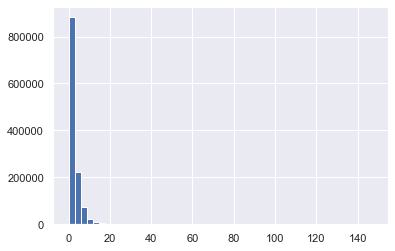

In [29]:
plt.hist(df['trip_distance'], bins = 50) 
#from the value counts given above we could set bins to simplify the histogram by shrinkaging the value range.
plt.ticklabel_format(style='plain') # to prevent scientific notation.
plt.show()

<AxesSubplot:xlabel='trip_distance'>

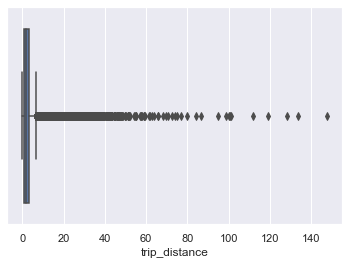

In [30]:
sns.boxplot(df['trip_distance'])

### There are some obvious outliers.

## Trip Time

In [31]:
df['trip_time'].value_counts()

5.0       88647
6.0       85813
4.0       85171
7.0       80506
8.0       73899
          ...  
1288.0        1
969.0         1
874.0         1
778.0         1
251.0         1
Name: trip_time, Length: 1143, dtype: int64

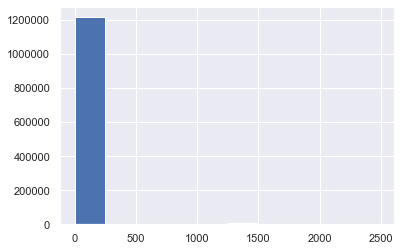

In [32]:
plt.hist(df['trip_time']) 
plt.ticklabel_format(style='plain')
plt.show()

### The reasons for 0 duration trips might be the driver deliberately entered the ride to complete a target number of rides, the passenger canceled the trip, or the dropoff datetime couldn't be tracked, etc..

### Let's see if 0-duration trips are also 0-distance trips.

In [33]:
df[df.trip_distance==0].head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,trip_region,trip_time,trip_speed,trip_logdist,pickup_hour,dropoff_hour,pickup_day,dropoff_day,pickup_timeofday,dropoff_timeofday
212,2,2016-12-01 00:36:38,2016-12-01 00:36:39,N,5,53,53,1,0.0,10.0,...,within_boro,0.0,NaN,-4.60517,0,0,Thursday,Thursday,Midnight,Midnight
422,2,2016-12-01 00:42:37,2016-12-01 00:42:41,N,1,228,228,1,0.0,2.5,...,within_boro,0.0,NaN,-4.60517,0,0,Thursday,Thursday,Midnight,Midnight
450,2,2016-12-01 00:00:30,2016-12-01 00:10:12,N,1,42,74,1,0.0,7.0,...,within_boro,9.0,0.0,-4.60517,0,0,Thursday,Thursday,Midnight,Midnight
451,2,2016-12-01 00:17:38,2016-12-01 00:19:49,N,1,75,74,1,0.0,3.5,...,within_boro,2.0,0.0,-4.60517,0,0,Thursday,Thursday,Midnight,Midnight
452,2,2016-12-01 00:39:41,2016-12-01 00:51:54,N,1,42,116,1,0.0,8.5,...,within_boro,12.0,0.0,-4.60517,0,0,Thursday,Thursday,Midnight,Midnight


In [34]:
df[df.trip_distance==0].tail()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,trip_region,trip_time,trip_speed,trip_logdist,pickup_hour,dropoff_hour,pickup_day,dropoff_day,pickup_timeofday,dropoff_timeofday
1223305,2,2016-12-31 23:54:13,2016-12-31 23:54:16,N,5,89,89,1,0.0,8.0,...,within_boro,0.0,NaN,-4.60517,23,23,Saturday,Saturday,Midnight,Midnight
1223431,2,2016-12-31 23:43:10,2016-12-31 23:43:12,N,5,9,9,1,0.0,40.0,...,within_boro,0.0,NaN,-4.60517,23,23,Saturday,Saturday,Midnight,Midnight
1223464,2,2016-12-31 23:27:21,2016-12-31 23:27:45,N,2,80,80,4,0.0,52.0,...,airport,0.0,NaN,-4.60517,23,23,Saturday,Saturday,Midnight,Midnight
1223557,1,2016-12-31 23:56:32,2016-12-31 23:56:35,N,1,49,49,1,0.0,0.0,...,within_boro,0.0,NaN,-4.60517,23,23,Saturday,Saturday,Midnight,Midnight
1223708,1,2016-12-31 23:40:14,2016-12-31 23:40:23,N,1,37,37,1,0.0,2.5,...,within_boro,0.0,NaN,-4.60517,23,23,Saturday,Saturday,Midnight,Midnight


### We can see from the tables above that some 0-distance trips have a long duration, while many more of them are within a few seconds. This might be because the dropoff location weren't recorded or passengers canceled their trips.

## Fare Amount

In [35]:
df['trip_distance'].value_counts()

0.90      15655
0.80      15398
1.00      15304
0.00      15183
1.10      14173
          ...  
111.91        1
31.60         1
44.24         1
47.60         1
29.88         1
Name: trip_distance, Length: 3052, dtype: int64

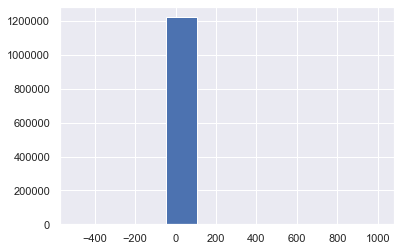

In [36]:
plt.hist(df['fare_amount']) 
plt.ticklabel_format(style='plain')
plt.show()

### All above lead us to find that not all data from the dataset are available. Some values are abnormal and extremely different from others. We should remove these data to simplify our data analysis. The criteria are shown below:
### Time Distance over 50 miles or equals 0;
### Trip time over 200 minutes or equals 0;
### Average speed lower than 1 MPH or higher than 240 MPH;
### Base fare lower than 2.50 or higher than 250.00, or tip amount higher than twice the base fare;

In [37]:
criterion1 = (df['trip_distance']==0) & (df['pickup_boro']!=df['dropoff_boro']) 
criterion2 = (df['trip_distance']>0) & (df['trip_distance']<50) 

len_df = len(df)
df = df [criterion1 | criterion2]
print('Criterion 1 removes',len_df - len(df),'records, sample size is now',len(df))

criterion3 = (df['trip_time']==0) & (df['pickup_boro']!=df['dropoff_boro'])
criterion4 = (df['trip_time']>0) & (df['trip_time'] <200) 

len_df = len(df)
df = df [criterion3 | criterion4]
print('Criterion 2 removes',len_df - len(df),'records, sample size is now',len(df))

criterion5 = ((df['trip_speed']< 4) & (df['trip_speed'] > 0.016))|(df['trip_distance']==0) | (df['trip_time'] ==0) 

len_df = len(df)
df = df [criterion5]
print('Criterion 3 removes',len_df - len(df),'records, sample size is now',len(df))

criterion6 = (df['fare_amount']>=2.5) & (df['fare_amount'] < 250)
criterion7 = df['tip_amount'] <= 2*df['fare_amount']

len_df = len(df)
df = df [criterion6 & criterion7]
print('Criterion 4 removes',len_df - len(df),'records, sample size is now',len(df))

Criterion 1 removes 13509 records, sample size is now 1210649
Criterion 2 removes 17329 records, sample size is now 1193320
Criterion 3 removes 972 records, sample size is now 1192348
Criterion 4 removes 4410 records, sample size is now 1187938


### One thing worths mentioning here is that, when it comes to long-distance trips, drivers might not have calculated price over the meter, since fares of some long-distance trips are negotiated or on a flat rate. As a result, 0-distance trips or 0-time trips were recorded if cross-borough. The trip distances and trip times of these kind of trips are imputed based on their rate code, fare amount, and the median speed of all trips with valid trip distance and time.

In [38]:
# We use median instead of mean here to avoid the effect of outliers
speed_md = df['trip_speed'].loc[(df['trip_distance']>0) & (df['trip_time']>0)].median()

distance_err = (df['trip_distance']==0) & (df['trip_time']>0)
time_err = (df['trip_distance']>0) & (df['trip_time']==0)
ratecode_err = (df['trip_distance']==0) & (df['trip_time']==0) & (df['RatecodeID']==2)
other_err = (df['trip_distance']==0) & (df['trip_time']==0) & (df['RatecodeID']!=2)

# replace trips with distance = 0 and time > 0 with median of speed * trip time                                  
df['trip_distance'].loc[distance_err] = df['trip_time'].loc[distance_err]*speed_md

# replace trips with distance > 0 and time = 0 with trip distance/median speed 
df['trip_time'].loc[time_err] = df['trip_distance'].loc[time_err]/speed_md

# replace trips with distance = 0, time = 0 and rate code = 2 with median distance and time for rate code = 2
df['trip_time'].loc[ratecode_err] = df['trip_time'].loc[(df['trip_distance']>0) & (df['trip_time']>0) \
                                                      & (df['RatecodeID']==2)].median()
df['trip_distance'].loc[ratecode_err] = df['trip_distance'].loc[(df['trip_distance']>0) & (df['trip_time']>0) \
                                                      & (df['RatecodeID']==2)].median()

# replace trips with distance = 0, time = 0 and rate code !=2 with median distance, time/fare
time_p_usd = df['trip_time']/df['fare_amount']
distance_p_usd = df['trip_distance']/df['fare_amount']

df['trip_time'].loc[other_err] = df['fare_amount'].loc[other_err] * time_p_usd.median()
df['trip_distance'].loc[other_err] = df['fare_amount'].loc[other_err] * distance_p_usd.median()

# recalculation after imputation
df['trip_speed'] = df['trip_distance']/df['trip_time']

In [39]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,trip_region,trip_time,trip_speed,trip_logdist,pickup_hour,dropoff_hour,pickup_day,dropoff_day,pickup_timeofday,dropoff_timeofday
0,2,2016-12-01 00:00:54,2016-12-01 00:06:54,N,1,92,192,1,1.29,6.5,...,within_boro,6.0,0.2150,0.262364,0,0,Thursday,Thursday,Midnight,Midnight
1,2,2016-12-01 00:52:41,2016-12-01 00:54:51,N,1,92,171,1,0.64,4.0,...,within_boro,2.0,0.3200,-0.430783,0,0,Thursday,Thursday,Midnight,Midnight
2,2,2016-12-01 00:10:39,2016-12-01 00:14:47,N,1,75,238,2,0.89,5.5,...,boro_downtown,4.0,0.2225,-0.105361,0,0,Thursday,Thursday,Midnight,Midnight
3,2,2016-12-01 00:12:16,2016-12-01 00:15:31,N,1,166,151,1,0.66,4.5,...,boro_downtown,3.0,0.2200,-0.400478,0,0,Thursday,Thursday,Midnight,Midnight
4,2,2016-12-01 00:29:22,2016-12-01 00:39:51,N,1,166,42,1,2.15,9.5,...,within_boro,10.0,0.2150,0.770108,0,0,Thursday,Thursday,Midnight,Midnight


## Now we can plot a histogram of counts of our target variable - Trip Distance.

The average trip distance = 2.7 , the standard deviation = 2.8
The median trip distance = 1.7 , 95% of trip distances are from 0.42 to 10.2


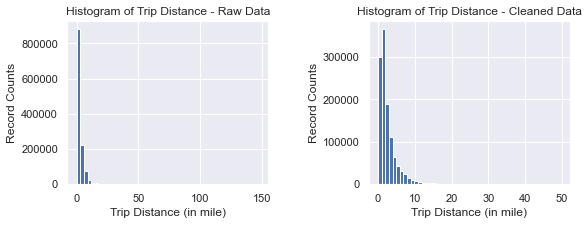

In [40]:
# trip distance histogram with raw data and cleaned data
fig, axs = plt.subplots(1,2)
fig.set_size_inches(9, 3)
fig.subplots_adjust(wspace=.5)

axs[0].hist(data['trip_distance'],bins=50);
axs[0].set_title('Histogram of Trip Distance - Raw Data')
axs[0].set_xlabel('Trip Distance (in mile)')
axs[0].set_ylabel('Record Counts')

axs[1].hist(df['trip_distance'],bins=50);
axs[1].set_title('Histogram of Trip Distance - Cleaned Data')
axs[1].set_xlabel('Trip Distance (in mile)')
axs[1].set_ylabel('Record Counts');

print('The average trip distance =',round(df['trip_distance'].mean(),1),', the standard deviation =',round(df['trip_distance'].std(),1))
print('The median trip distance =',round(df['trip_distance'].median(),1),', 95% of trip distances are from',
      round(df['trip_distance'].quantile(.025),2),'to',round(df['trip_distance'].quantile(.975), 1))

### The distribution of raw-data trip distance is very right skewed, with most of them falling on the lower range and only a few large values which are not implausible. The problem of right skewness is reduced by our data cleaning. In the cleaned dataset, the average distance is 2.7 , the standard deviation is 2.8.; the median distance is 1.7, and the 95% of trips distance fall between 0.42 and 10.2. Because of the high right-skewness of the trip distance data, the median distance is a better than the mean distance in measuring overall trip distance.

### We can make an assumption that the distribution might follow a log-normal distribution based on the histograms above. This hypothesis is supported by the closeness to normal distribution of log transformed trip distances, as well as the QQ plot shown below, in which the tracked values are very close to the expected values.

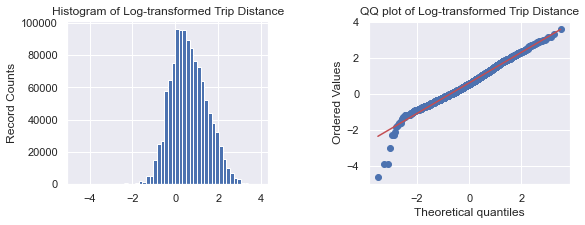

In [41]:
df['trip_logdist'] = df['trip_distance'].apply(lambda x: np.log(x))
df = df[np.isfinite(df['trip_logdist'])]

fig, axs = plt.subplots(1,2)
fig.set_size_inches(9, 3)
fig.subplots_adjust(wspace=.5)

axs[0].hist(df['trip_logdist'], bins=50);
axs[0].set_title('Histogram of Log-transformed Trip Distance')
axs[0].set_ylabel('Record Counts');

stats.probplot(df['trip_logdist'].sample(3000), dist="norm", plot=axs[1])
axs[1].set_title('QQ plot of Log-transformed Trip Distance');

# Question 3.  [Interesting Trip Statistics Grouped by Hour]

## Trip distance per hour of week

<AxesSubplot:xlabel='pickup_hour', ylabel='trip_distance'>

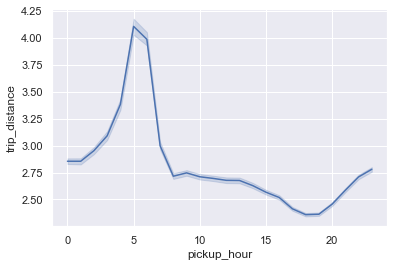

In [42]:
sns.lineplot(x='pickup_hour', y='trip_distance', data=df)

### Longest trips are more likely to happen around 5am. What's the reason? Will it be related to airport trips which oftern occur around this time? Let's conduct analysis on this now.

### Let's first look at the mean and median trip distance grouped by hour.

In [43]:
dis_hr = df[['trip_distance','pickup_hour']].groupby(by='pickup_hour').mean()
dis_hr.columns=['trip_distance_mean']
dis_hr['trip_distance_medium']=df[['trip_distance','pickup_hour']].groupby(by='pickup_hour').median()
dis_hr

,trip_distance_mean,trip_distance_medium
pickup_hour,,
0,2.854463,1.90
1,2.854388,1.92
2,2.952423,2.00
3,3.090569,2.10
4,3.382069,2.22
5,4.104611,2.77
6,3.984922,2.73
7,2.998429,1.90
8,2.715750,1.70


### Mean trip distances are higher than median trip distances in general grouped by hour. This might be because of its right-skewed distribution, and the means are bigger possibly because of some outliers. Therefore, the medians could better stand for the overall tendency of trip distances.

In [44]:
# Define airport trips
## rate code = 2/3; pickup or dropoff at JFK, LGA, or EWR
air = (df['RatecodeID'].isin([2,3]))| (df['pickup_boro'].isin(['JFK','LGA','EWR'])) | (df['dropoff_boro'].isin(['JFK','LGA','EWR']))

df['airport_trip'] = 'nonairport'
df['airport_trip'].loc[air] = 'airport'

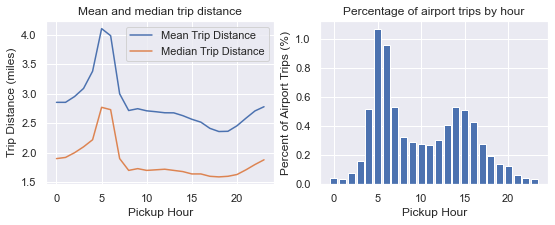

In [45]:
# Percent of airport and non-airport trips grouped by hour
trip_cnt = df.groupby(by=['pickup_hour','airport_trip']).count()['trip_distance'].unstack()
trip_cnt['total'] = trip_cnt['airport'] + trip_cnt['nonairport'] 
trip_cnt['airport_pct'] = 100 * trip_cnt['airport']/trip_cnt['total']
trip_cnt['nonairport_pct'] = 100 * trip_cnt['nonairport']/trip_cnt['total']

fig, ax = plt.subplots(1,2)
fig.set_size_inches(9, 3)

dis_hr.plot(ax=ax[0]);
ax[0].set(xlabel='Pickup Hour', ylabel='Trip Distance (miles)')
ax[0].set_title('Mean and median trip distance')
ax[0].legend(['Mean Trip Distance', 'Median Trip Distance'])

t = list(range(24))
ax[1].bar(t, trip_cnt['airport_pct'])
ax[1].set(xlabel='Pickup Hour', ylabel='Percent of Airport Trips (%)')
ax[1].set_title('Percentage of airport trips by hour');

### Based on the median-trip-distance figure above, we know that the trip distance fluctuates around 2 miles throughout the day. Trips occuring between 4:00 PM and 6:00 PM seems to be the shortest, and trips occuring around 4:00 AM to 6:00 AM are the longest. The long-distance trips happened in the morning could possibly be a result of the airport rides as we can see from the right-side figure, which show most of the airport trips are between 5:00 AM to 6:00 AM.

## Trips per Hour

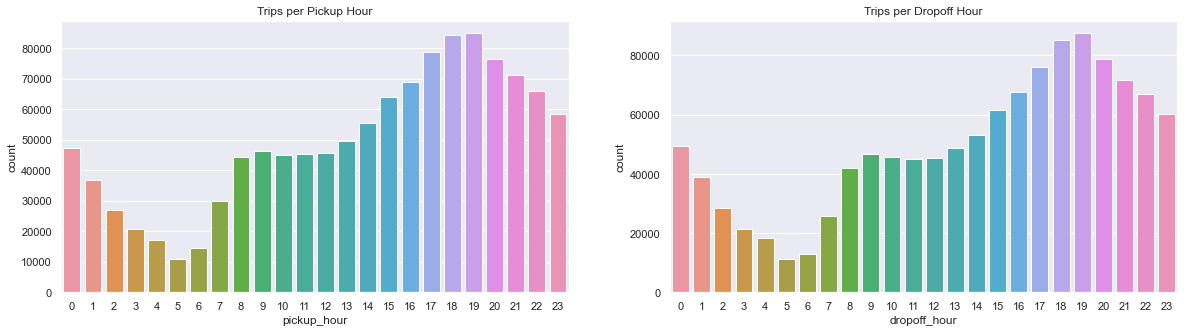

In [46]:
figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))
ax3.set_title("Trips per Pickup Hour")
ax=sns.countplot(x="pickup_hour",data=df,ax=ax3)
ax4.set_title("Trips per Dropoff Hour")
ax=sns.countplot(x="dropoff_hour",data=df,ax=ax4)

### We can see that 6:00 pm to 7:00 pm are the busiest hours of a day and this is possibly because it's time when people are leaving from work.

## Trip Speed per Hour

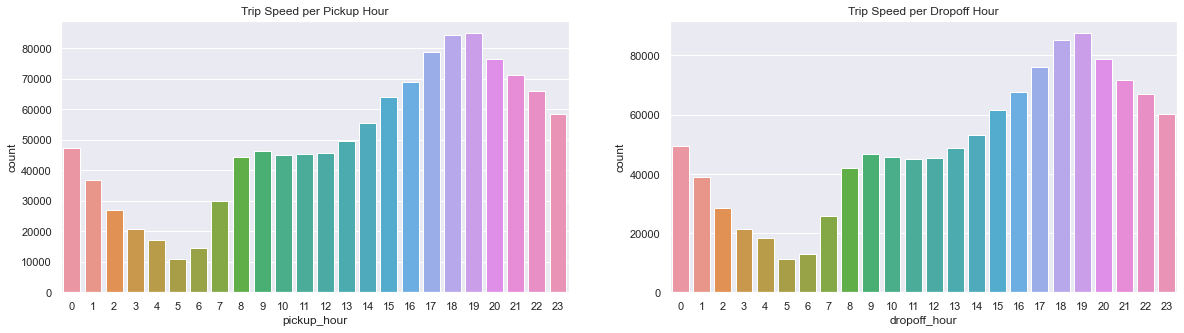

In [47]:
figure,(ax7,ax8)=plt.subplots(ncols=2,figsize=(20,5))
ax7.set_title("Trip Speed per Pickup Hour")
ax=sns.countplot(x="pickup_hour",data=df,ax=ax7)
ax8.set_title("Trip Speed per Dropoff Hour")
ax=sns.countplot(x="dropoff_hour",data=df,ax=ax8)

### The trip speed over the 24 hours of a day is shown above. Trips in the early morning and midnight seems to be the fastest. 

# Question 4. [Trips with Better Tips and Modeling]

## We can create a new variable, tip percentage, which could be derived from the tip amount and total amount.

In [48]:
df['tip_percentage'] = 100 * df['tip_amount']/df['total_amount']

## Then let's build a predictive model for tip percentage. We're using as much data as we can in order to take all candidate features into account. Then we're going to assess its performance using a sample.

## Data Cleaning: 
#### Since only transactions with credit card payment are available, and some rides were paid after negotiation and there were no tips, we could remove these redundant data for simplicity.
#### Trips with 0 passenger are imputed by 1 as it shows the highest frequency in passenger count.
#### Missing trip type was imputed by street-hail which has the highest frequency as well

## Feature engineering and data cleaning:
#### Features indicating day of week, week of month and workday or weekend are created based on pickup date and time. 

In [49]:
df['passenger_count'].loc[df['passenger_count']==0] = 1
df['trip_type'].loc[df['trip_type'].isnull()] = 1

In [50]:
df['week'] = df['lpep_pickup_datetime'].dt.week.astype(str)

df['weekend'] = 'weekday'
df['weekend'].loc[df['pickup_day'].isin(['Saturday','Sunday'])] = 'weekend'

df['day'] = df['lpep_pickup_datetime'].dt.day.astype(str)

In [51]:
filter1 = df['payment_type']==1
filter2 = (df['RatecodeID']!=5) | (df['tip_percentage']!=0)
final_df = df[filter1 & filter2]

# Convert categorical variables into continuous variables, passenger count into passenger range
final_df['passenger_range'] = pd.Series(pd.cut(final_df['passenger_count'], [0, 2, 5,9], 
                                        labels=['1-2','3-5','5-9'], retbins=False, right=True))

# convert distance into distance range
final_df['distance_range'] = pd.Series(pd.cut(final_df['trip_distance'], [0, 1.32, 2.47,4.5,50], 
                                        labels=['Q1','Q2','Q3','Q4'], retbins=False, right=False))

# conver time into time range
final_df['time_range'] = pd.Series(pd.cut(final_df['trip_time'],[0,7,12,19,200],labels=['Q1','Q2','Q3','Q4'],
                                    include_lowest=True, right=False,retbins=False))

# conver pick up hour and drop off hour into time intervals
labels=['0-1','2-3','4-5','6-7','8-9','10-11','12-13','14-15','16-17','18-19','20-21','22-23']
final_df['pickuphour_range'] = pd.Series(pd.cut(final_df['pickup_hour'], list(np.arange(0,25,2)), labels=labels,right=False))
final_df['dropoffhour_range'] = pd.Series(pd.cut(final_df['dropoff_hour'], list(np.arange(0,25,2)), labels=labels,right=False))
final_df['speed_range'] = pd.Series(pd.cut(final_df['trip_speed'],[0,0.17,0.21,0.28,3],labels=['Q1','Q2','Q3','Q4'],
                                    include_lowest=True, right=False,retbins=False))

### We can then plot the distribution of tip percentage

Skewness: -0.549160
Kurtosis: 1.163093
The average tip percentage = 14.1 , the standard deviation is 7.2
The median tip percentage = 16.7 , 95% of tip percentage are between 0.0 and 23.1


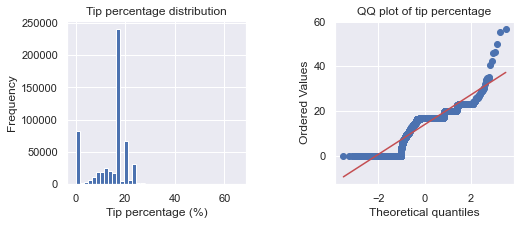

In [52]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
fig.subplots_adjust(wspace=.5)

ax[0].hist(final_df['tip_percentage'], bins=40)
ax[0].set(xlabel='Tip amount ($)', ylabel='Trip Count');
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Tip percentage (%)')
ax[0].set_title('Tip percentage distribution')

stats.probplot(final_df['tip_percentage'].sample(3000), dist="norm", plot=ax[1])
ax[1].set_title('QQ plot of tip percentage')

print("Skewness: %f" % final_df['tip_percentage'].skew())
print("Kurtosis: %f" % final_df['tip_percentage'].kurt())
print('The average tip percentage =',round(final_df['tip_percentage'].mean(),1),', the standard deviation is',round(final_df['tip_percentage'].std(),1))
print('The median tip percentage =',round(final_df['tip_percentage'].median(),1),', 95% of tip percentage are between',
      round(final_df['tip_percentage'].quantile(.025),2),'and',round(final_df['tip_percentage'].quantile(.975), 1))

#### The tip percentage does not follow the normal distribution as we can see from the left-hand figure above, and there are some typical values that are most centered-around, i.e., 0%, 16.7%, 20%, 23%. We cannot help thinking of the values of 0%, 20%, 25%, and 30% which are preset tipping options at checkout because of their closeness to our observed center tipping  values. We could assume that many passengers gave the chose tipping options or skipped tipping.

## Feature Selection

#### Since the feature “store_and_fwd_flag” is obviously irrelevant to tip percentage, and “payment_type” is uniform for all observations, both of them are excluded from our model.

#### We can first have a look at the matrix of barplot for continuous variables

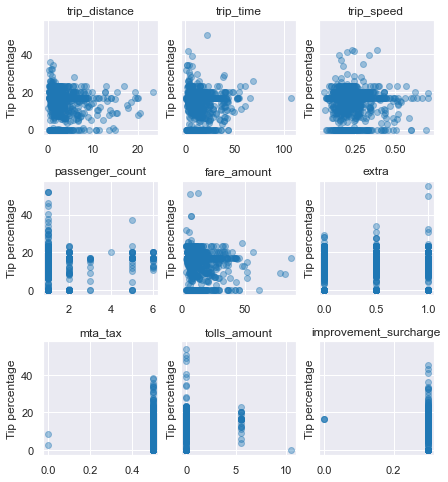

In [53]:
fig, ax = plt.subplots(3,3,figsize=(7,8), sharey=True)
fig.subplots_adjust(hspace=.4)

ad_list =['trip_distance','trip_time', 'trip_speed', 'passenger_count', 
            'fare_amount', 'extra', 'mta_tax','tolls_amount', 'improvement_surcharge']

for i, var in enumerate(ad_list):
    c = int(i/3)
    r = (i+3) % 3
    ax[c][r].scatter(x=var, y="tip_percentage", data=final_df.sample(1000),color='#1f77b4', alpha=.4)
    ax[c][r].set(title=var, ylabel='Tip percentage');

#### Then comes the barplot of categorical variables

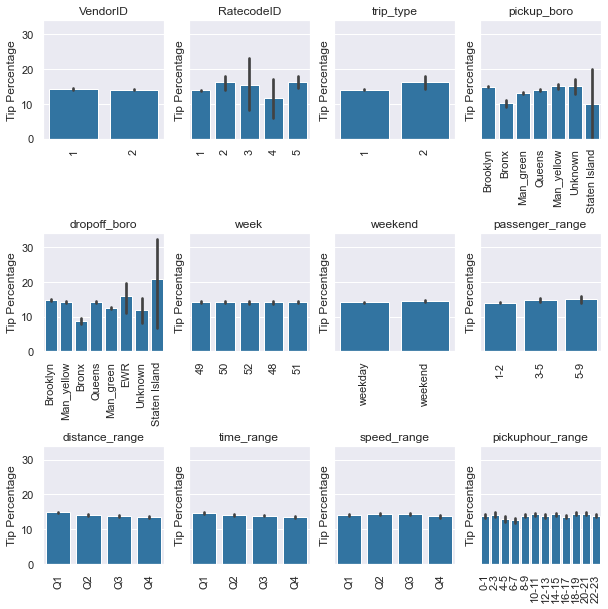

In [54]:
fig, ax = plt.subplots(3,4,figsize=(10, 10), sharey=True)
fig.subplots_adjust(wspace=.2, hspace=.8)

tp_list =['VendorID','RatecodeID', 'trip_type',  'pickup_boro', 'dropoff_boro', 
           'week', 'weekend','passenger_range','distance_range','time_range',
           'speed_range', 'pickuphour_range']

for i, var in enumerate(tp_list):
    c= int(i/4)
    r = (i+4) % 4
    sns.barplot(x=var, y="tip_percentage", data=final_df.sample(10000),color='#1f77b4', ax=ax[c][r])#sample to reduce computation time
    ax[c][r].set(title=var,ylabel='Tip Percentage',xlabel='')
    ax[c][r].set_xticklabels(ax[c][r].get_xticklabels(),rotation=90);

#### Figures above respectively show the relationship between tip percentage and continuous features as well as tip percentage and categorical features. We could tell that trip distance and trip time are not in linearly correlation with tip percentage and thus are converted into categorical variables as ranges. Since we drive trip speed from trip distance and time, considering colinearity we are not considering this variable into account in our model building.

## Model Fitting and Assessment

## Linear Regression

In [55]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import mse
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures,StandardScaler

In [56]:
final_df = pd.get_dummies(final_df, columns=['pickup_day','passenger_range','pickuphour_range','dropoffhour_range',
                                   'distance_range','time_range','speed_range','dropoffhour_range',
                                   'trip_region','pickup_boro','dropoff_boro','week','weekend','RatecodeID',
                                   'VendorID'],
                     drop_first =True)

In [57]:
# Generate a dataframe mapper 
dfmap = DataFrameMapper([
    (['fare_amount', 'extra','tolls_amount', 'mta_tax','improvement_surcharge','trip_type'],[StandardScaler()]),
        (['distance_range_Q2','distance_range_Q3', 'distance_range_Q4',
         'time_range_Q2','time_range_Q3', 'time_range_Q4',
         'passenger_range_3-5', 'passenger_range_5-9', 
         'pickuphour_range_2-3','pickuphour_range_4-5', 
         'pickuphour_range_6-7', 'pickuphour_range_8-9',
         'pickuphour_range_10-11', 'pickuphour_range_12-13',
         'pickuphour_range_14-15', 'pickuphour_range_16-17',
         'pickuphour_range_18-19', 'pickuphour_range_20-21',
         'pickuphour_range_22-23', 
         'pickup_boro_Brooklyn','pickup_boro_Man_green',
         'pickup_boro_Man_yellow', 'pickup_boro_Queens','pickup_boro_Staten Island', 
         'dropoff_boro_Brooklyn', 'dropoff_boro_EWR', 'pickup_boro_Unknown',
         'dropoff_boro_Man_green','dropoff_boro_Man_yellow','dropoff_boro_Queens', 
         'dropoff_boro_Staten Island', 'dropoff_boro_Unknown',
         'week_49','week_50', 'week_51', 'week_52',
         'RatecodeID_2', 'RatecodeID_3','RatecodeID_4', 'RatecodeID_5',
         'weekend_weekend', 'VendorID_2'], None)])

In [58]:
# Let's first build an Ordinary Least Squares Model using Statsmodel
X = dfmap.fit_transform(final_df)
y = final_df['tip_percentage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
predictions = model.predict(sm.add_constant(X_test))

#Summary
print('RMSE of baseline model with the mean tip percentage is',np.sqrt(mse(y_test.mean(),y_test)))
print('RMSE of the full model is',np.sqrt(mse(predictions, y_test)))
print('R-square of the full model is',explained_variance_score(y_test, predictions))
model.summary()

RMSE of baseline model with the mean tip percentage is 7.181998566933175
RMSE of the full model is 7.023854281089008
R-square of the full model is 0.04356048967039794


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tip_percentage   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     347.7
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        02:19:11   Log-Likelihood:            -1.3385e+06
No. Observations:              397040   AIC:                         2.677e+06
Df Residuals:                  396991   BIC:                         2.678e+06
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3211      0.103     90.811      0.000       9.120       9.522
x1            -0.3316      0.025    -13.064      0.000      -0.381      -0.282
x2            -0.1142      0.019     -5.996      0.000      -0.152      -0.077
x3             0.1493      0.013     11.253      0.000       0.123       0.175
x4            -0.1013      0.112     -0.908      0.364      -0.320       0.117
x5            -0.0169      0.029     -0.579      0.562      -0.074       0.040
x6            -0.1143      0.095     -1.201      0.230      -0.301       0.072
x7            -0.1896      0.039     -4.881      0.000      -0.266      -0.113
x8            -0.4239      0.051     -8.294      0.000      -0.524      -0.324
x9            -0.3639      0.069     -5.283      0.000      -0.499      -0.229
x10           -0.5278      0.039    -13.659      0.000      -0.604      -0.452
x11           -0.7996      0.051    -15.782      0.000      -0.899      -0.700
x12           -0.9542      0.065    -14.612      0.000      -1.082      -0.826
x13            0.0873      0.047      1.862      0.063      -0.005       0.179
x14            0.1194      0.085      1.411      0.158      -0.046       0.285
x15           -0.2289      0.069     -3.300      0.001      -0.365      -0.093
x16           -0.6772      0.087     -7.813      0.000      -0.847      -0.507
x17           -1.0296      0.076    -13.594      0.000      -1.178      -0.881
x18           -0.4389      0.065     -6.787      0.000      -0.566      -0.312
x19           -0.1184      0.065     -1.807      0.071      -0.247       0.010
x20           -0.1306      0.065     -2.004      0.045      -0.258      -0.003
x21           -0.2718      0.063     -4.329      0.000      -0.395      -0.149
x22           -0.1419      0.054     -2.604      0.009      -0.249      -0.035
x23            0.0494      0.052      0.949      0.343      -0.053       0.151
x24            0.0764      0.052      1.458      0.145      -0.026       0.179
x25           -0.0259      0.054     -0.482      0.630      -0.131       0.079
x26            2.9238      0.098     29.914      0.000       2.732       3.115
x27            1.6802      0.090     18.700      0.000       1.504       1.856
x28            2.2937      0.121     18.893      0.000       2.056       2.532
x29            1.9411      0.101     19.214      0.000       1.743       2.139
x30           -0.2382      1.168     -0.204      0.838      -2.528       2.051
x31            3.5435      0.087     40.779      0.000       3.373       3.714
x32            4.4143      0.566      7.802      0.000       3.305       5.523
x33            2.0757      0.358      5.799      0.000       1.374       2.777
x34            2.1751      0.079     27.659      0.000       2.021       2.329
x35            4.3817      0.079     55.704      0.000       4.228       4.536
x3

#### We first used linear regression with the ordinary least square method, and the summary is shown above. We made a comparison between the full model with all features and a baseline model with intercept only, just regarding mean as predicted value. As we can see from R2 = 0.04, the full model is not very explantory for the extra variance in tip percentage compared to the baseline model. The predicted tip percentage will be ±7.02% from its actual value given RMSE = 7.02%.
#### From the figure above, we can tell that following types of trips yield higher tip percentages: shorter trip time and distance, higher toll fee, faster speed, more passenger counts, lower fare amount and extra charge,  pickup time after 6:00 PM, dropoff location at airports, Manhattan downtown, and Staten Island, and weekend trips.

#### We can then conduct sensitivity analysis by excluding trips with tip percentage that are over 50% since it's far from the normal range.

In [59]:
fd_s = final_df.loc[final_df['tip_percentage']<=50]

X_s= dfmap.fit_transform(fd_s)
y_s= fd_s['tip_percentage']
X_train_s, X_test_s, y_train_s, y_test_s= train_test_split(X_s, y_s, test_size=0.3, random_state=43)

model_s = sm.OLS(y_train_s, sm.add_constant(X_train_s)).fit()
predictions_s = model_s.predict(sm.add_constant(X_test_s)) 

# Print out the statistics
print('There are', len(final_df)-len(fd_s),'trips with tip percentage over 50% in total')
print('RMSE of baseline model with the mean tip percentage is',np.sqrt(mse(y_test_s.mean(), y_test_s)))
print('RMSE of the full model is',np.sqrt(mse(predictions_s, y_test_s)))
print('R-square of the full model is',explained_variance_score(y_test_s, predictions_s))

There are 386 trips with tip percentage over 50% in total
RMSE of baseline model with the mean tip percentage is 7.117104385508001
RMSE of the full model is 6.972186694619519
R-square of the full model is 0.040309391164603414


#### The model fit has been improved by removing the extreming values as we can tell by the decrease in RMSE and rise in R-squared.

## Regularization and Gradient Boosting

### We can advance into fitting Ridge, Gradient Boosting model and XGBoost model to predict tip percentage. I've tuned hyperparameters by grid search and 3-fold cross-validation using the training dataset. Then I evaluated the model fit in the testing dataset.

In [61]:
%%time
results = fit_model(final_df, dfmap)

Model begins
Linear regression model training
Gradientboost regressor model training
XGboost regressor model training
Model ends
CPU times: user 1h 8min 23s, sys: 9min 27s, total: 1h 17min 50s
Wall time: 14min 33s


In [62]:
#model performances
results_table=results[['model_type','test_exp_var','test_MSE','test_RMSE']]
results_table

,model_type,test_exp_var,test_MSE,test_RMSE
0,ridge,0.041861,49.514938,7.036685
1,gbr,0.046270,49.287024,7.020472
2,xgb,0.044531,58.463012,7.646111


#### As we can tell from the table above, these advanced models have not improved the model fit. In this case, we would prefer linear regression because of its good interpretability and fast speed.

## Summary

#### In conclusion, the model performance of multivariable linear regression is unsatisfactory due to R2 and RMSE. However, regularization or gradient boosting methods have not improved the model fit. As a result, we would recommend not using tip percentage as a prediction target in the future. Besides, from the beta coefficients of linear regression model, we know that taxi trips with shorter trip time and distance, higher toll fee, faster speed, more passenger counts, lower fare amount and extra charge, pickup time after 6:00 PM, dropoff location at airports, Manhattan downtown, and Staten Island, and weekend rides could yield better tips. 
#### I'm now going to improve the predictability of tips for NYC green taxis by conducting the following analysis.

### What causes the poor performance of the model?

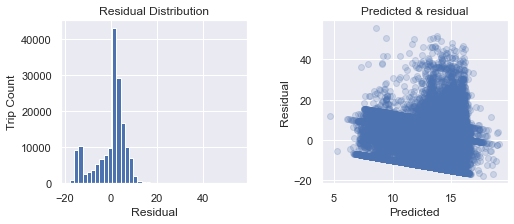

In [63]:
rsd = y_test-predictions
fig, ax = plt.subplots(1,2,figsize=(8,3))
fig.subplots_adjust(wspace=.4)

# check if the residual follows a normal distribution
ax[0].hist(rsd, bins = 40);
ax[0].set(xlabel='Residual', ylabel='Trip Count', title='Residual Distribution');

# check if the residual distribution is dependent on y
ax[1].scatter(predictions, rsd,alpha=.2);
ax[1].set(xlabel='Predicted', ylabel='Residual', title='Predicted & residual');

#### We now know that residuals do not follow the normal distribution, and are independent from predicted values as well. This could somewhat explain the poor performacnes of our models.
#### There are some extreme values disrupting the distribution, which could have resulted in the big prediction errors. For example, some 0% tips might have been paid in cash.

### Comparison between Preset & Custom Tip Percentage

Original Skewness: -0.549160
Original Kurtosis: 1.163093
Skewness after excluding preset tips: 1.589601
Kurtosis after excluding preset tips: 6.592637


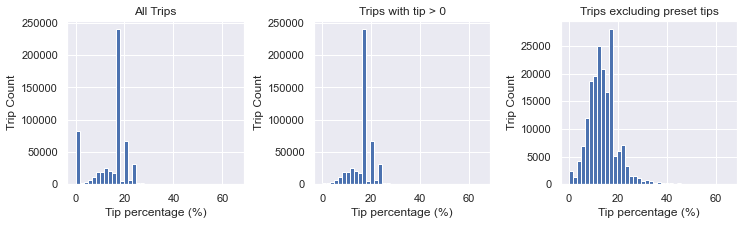

In [64]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
fig.subplots_adjust(wspace=.4)

ax[0].hist(final_df['tip_percentage'], bins=40)
ax[0].set(xlabel='Tip percentage (%)', ylabel='Trip Count');
ax[0].set_title('All Trips');

ax[1].hist(final_df['tip_percentage'].loc[(final_df['tip_percentage']>0)], bins=40);
ax[1].set(xlabel='Tip percentage (%)', ylabel='Trip Count');
ax[1].set_title('Trips with tip > 0');

custom = final_df['tip_percentage'].loc[~((df['tip_percentage']==0)|\
                                    ((df['tip_percentage']>16.6)&(df['tip_percentage']<16.7))|\
                                    ((df['tip_percentage']>19.9)&(df['tip_percentage']<20.1))|\
                                    ((df['tip_percentage']>23)&(df['tip_percentage']<23.1)))]
ax[2].hist(custom, bins=40);
ax[2].set(xlabel='Tip percentage (%)', ylabel='Trip Count');
ax[2].set_title('Trips excluding preset tips');

#fig.savefig('fig10.svg', format='svg',bbox_inches='tight')
print("Original Skewness: %f" % final_df['tip_percentage'].skew())
print("Original Kurtosis: %f" % final_df['tip_percentage'].kurt())

print("Skewness after excluding preset tips: %f" % custom.skew())
print("Kurtosis after excluding preset tips: %f" % custom.kurt())

#### The highly-skewed tip percentage distribution has negatively affect the normality of the residual distributions, contradicting to the important assumption of linear regression. Exluding the preset tip percentages makes the distribution of tip percentage closer to a normal distribution, with a more distinct shape (skewness=1.6, kurtosis=6.6) compared to the distribution of all tips (skewness= -0.5, kurtosis=1.1). Therefore, it might be best to divide the tip percentages into two parts, respectively custom tips and preset tips, and model and them separately. Through this process, we could begin with a classification model to predict if it's a preset- or custom-tip trip. Then we would categorize preset-tip trips into different preset-tip values, meanwhile for custom-tip trips,  we can build a prediction model to estimate the tip.

### Converting Tip Percentage to Tip Amount as the Response Variable

In [65]:
X = final_df[['fare_amount', 'extra','tolls_amount', 'mta_tax','improvement_surcharge','trip_type',
         'distance_range_Q2','distance_range_Q3', 'distance_range_Q4',
         'time_range_Q2','time_range_Q3', 'time_range_Q4',
         'passenger_range_3-5', 'passenger_range_5-9', 
         'pickuphour_range_2-3','pickuphour_range_4-5', 
         'pickuphour_range_6-7', 'pickuphour_range_8-9',
         'pickuphour_range_10-11', 'pickuphour_range_12-13',
         'pickuphour_range_14-15', 'pickuphour_range_16-17',
         'pickuphour_range_18-19', 'pickuphour_range_20-21',
         'pickuphour_range_22-23', 
         'pickup_boro_Brooklyn', 'pickup_boro_Man_green',
         'pickup_boro_Man_yellow', 'pickup_boro_Queens','pickup_boro_Staten Island', 
         'dropoff_boro_Brooklyn', 'dropoff_boro_EWR', 
         'dropoff_boro_Man_green','dropoff_boro_Man_yellow','dropoff_boro_Queens', 'dropoff_boro_Staten Island',
         'week_49','week_50', 'week_51', 'week_52',
         'RatecodeID_2', 'RatecodeID_3','RatecodeID_4', 'RatecodeID_5',
         'weekend_weekend', 'VendorID_2']]

y_1 = final_df['tip_amount']
X_train, X_test, y_train_amount, y_test_amount = train_test_split(X, y_1, test_size=0.3, random_state=43)
model_1 = sm.OLS(y_train_amount, sm.add_constant(X_train)).fit()
predictions_1 = model_1.predict(sm.add_constant(X_test))

print('RMSE of the baseline model with the mean tip percentage is',np.sqrt(mse(y_test_amount.mean(), y_test_amount)))
print('RMSE of the full model is',np.sqrt(mse(predictions_1, y_test_amount)))
print('R-squared of the full model is',explained_variance_score(y_test_amount, predictions_1))
predicted_total=predictions_1+X_test['fare_amount']+X_test['extra']+X_test['tolls_amount']+X_test['improvement_surcharge']+X_test['mta_tax']
predicted_tip_percentage=100*predictions_1/predicted_total
print('RSME of tip percent model is',np.sqrt(mse(predicted_tip_percentage, y_test)))

RMSE of the baseline model with the mean tip percentage is 2.2006677464005473
RMSE of the full model is 1.6129048098724519
R-squared of the full model is 0.4628358372434068
RSME of tip percent model is 7.086268846944302


### As we can see from above, the RMSE has been significantly decreased and the R-squared has been significantly increased by this method, which means we should set tip amount as our response variable in the future. Shown above is the ordiary least squared model, we are going to dive deeper into Regularization and Gradient Boosting models, with tip amount as response variable now.

In [66]:
%%time
results = fit_model(final_df, dfmap)

Model begins
Linear regression model training
Gradientboost regressor model training
XGboost regressor model training
Model ends
CPU times: user 42min 35s, sys: 5min 3s, total: 47min 39s
Wall time: 10min 45s


In [67]:
#model performances
results_table=results[['model_type','test_exp_var','test_MSE','test_RMSE']]
results_table

,model_type,test_exp_var,test_MSE,test_RMSE
0,ridge,0.041861,49.514938,7.036685
1,gbr,0.048918,49.150207,7.010721
2,xgb,0.049842,49.102139,7.007292


#### As we can tell from the table above, these advanced models have only slightly improved the model fit. In this case, we would prefer linear regression because of its good interpretability and fast speed.

# Question 5. [Visualize the Data to Help Understand Trip Patterns]

### We've visualized some data previously which covered some of the trip patterns, now we are going to dive deeper with trip patterns.

## Univariate Analysis

## Vendor ID

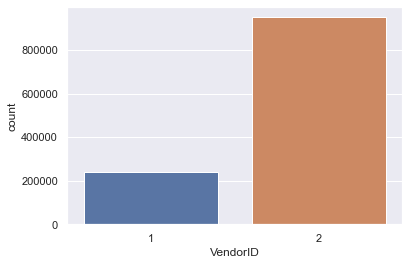

In [68]:
sns.countplot(x='VendorID', data = df)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

### The number of trips taken by Vendor 2 is much larger than the number of trips taken by Vendor 1.

## Passenger Count

In [69]:
df.passenger_count.value_counts()

1    1003622
2      90473
5      42367
3      23511
6      20175
4       7770
7          9
8          9
9          2
Name: passenger_count, dtype: int64

### We should keep in mind that there are some invalid trip records with no passenger. To know about the data more clearly we could plot a bar chart of passenger count as shown below.

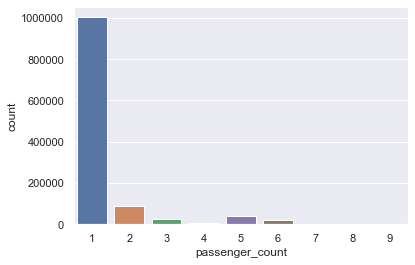

In [70]:
sns.countplot(x='passenger_count',data=df)
plt.ticklabel_format(style='plain', axis = 'y')
plt.show()

### When passenger count = 1 we have the highest amount of trips, and when passenger count is around 7 to 9 we have the lowest amount of trips.

### Why not remove the rows with 7-9 passenger count that are not important enough due to few trip counts, to obtain a fair distribution?

In [71]:
df = df[df['passenger_count']<=6]

In [72]:
df.passenger_count.value_counts()

1    1003622
2      90473
5      42367
3      23511
6      20175
4       7770
Name: passenger_count, dtype: int64

### Now we have a fair distribution.

## Store and Forward Flag

In [73]:
df['store_and_fwd_flag'].value_counts(normalize = True)

N    0.998318
Y    0.001682
Name: store_and_fwd_flag, dtype: float64

### Only less than 1% of trips were stored before forwarding.

## Trips per Day

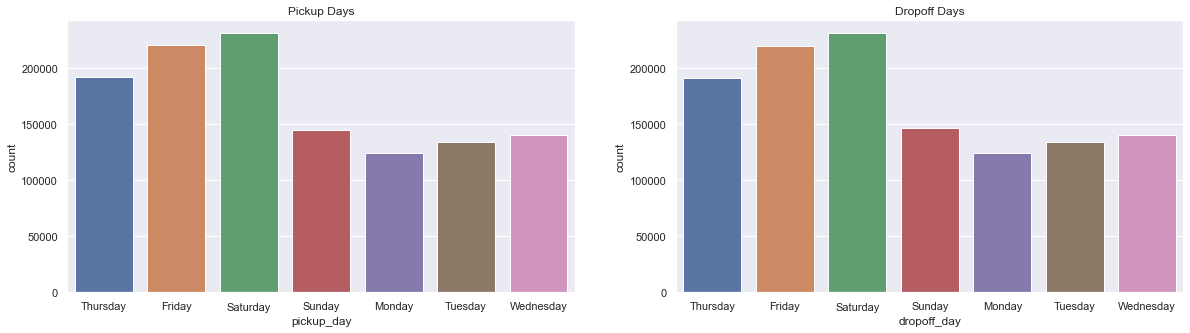

In [74]:
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize = (20,5))
ax1.set_title('Pickup Days')
ax = sns.countplot(x= "pickup_day",data=df,ax=ax1)
ax2.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_day",data=df,ax=ax2)

### We could see that Saturdays and Fridays are the busiest days in a week, which is probably because it's weekend.

## Trips per Time of Day

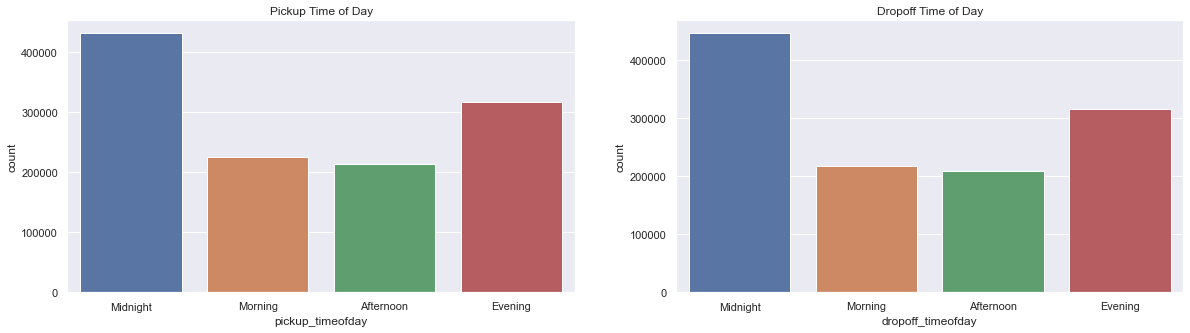

In [75]:
figure,(ax5,ax6)=plt.subplots(ncols=2,figsize=(20,5))
ax5.set_title('Pickup Time of Day')
ax=sns.countplot(x="pickup_timeofday",data=df,ax=ax5)
ax6.set_title('Dropoff Time of Day')
ax=sns.countplot(x="dropoff_timeofday",data=df,ax=ax6)

### We can see that midnights are the busiest.

## Location

In [76]:
df['PULocationID'].sort_values(ascending = False)

408439    265
552692    265
383112    265
842524    265
647337    265
         ... 
291832      3
473563      3
891706      3
738128      1
772063      1
Name: PULocationID, Length: 1187918, dtype: int64

### This result corresponds to the definition of the dictionary, which says the Location ID ranges from 1 to 265.

In [77]:
df.PULocationID.value_counts()

74     69892
41     67853
75     61016
7      60926
82     56630
       ...  
84         1
233        1
30         1
234        1
164        1
Name: PULocationID, Length: 236, dtype: int64

### Most Pickups are in LocationID with 74, and there are some LocationIDs only had one pickup in December 2016.

In [78]:
df['DOLocationID'].sort_values(ascending = False)

866120     265
845464     265
51343      265
622090     265
1139114    265
          ... 
263699       1
878514       1
338568       1
932882       1
764300       1
Name: DOLocationID, Length: 1187918, dtype: int64

### This result corresponds to the definition of the dictionary, which says the Location ID ranges from 1 to 265.

In [79]:
df.DOLocationID.value_counts()

42     39603
74     39415
7      37230
129    36117
41     35892
       ...  
176        5
204        4
44         3
110        1
99         1
Name: DOLocationID, Length: 260, dtype: int64

### Most Dropoffs are in LocationID with 42, and there are some LocationIDs only had one pickup in December 2016.

# Bivariate Analysis

## We can now analyze further with the data in Bivariate Analysis. It involves finding relationships, patterns, and correlations between two variables. We can utilize it to find what kind of trip yields better tips.

## Trip distance per vendor

<AxesSubplot:xlabel='VendorID', ylabel='trip_distance'>

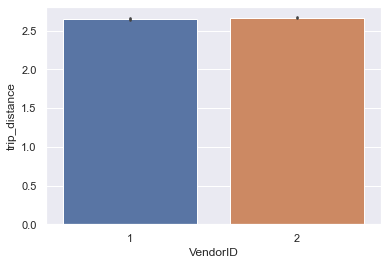

In [80]:
sns.barplot(y='trip_distance',x='VendorID',data=df,estimator=np.mean)

### There is not much difference in trip distance between Vendor 1 and 2.

## Trip distance per passenger count

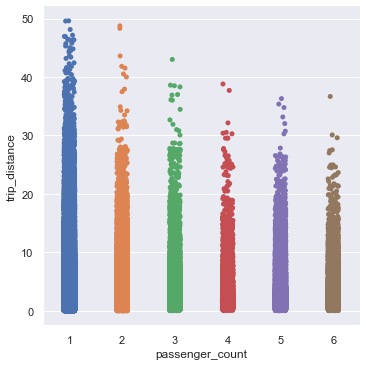

In [81]:
sns.catplot(y='trip_distance', x='passenger_count', data = df, kind = "strip")

### Longer trips are more likely to happen when passenger count is 1. The trip distance performances for passenger count of 2, 3, 4, 5 and 6 are pretty similar, and are all less likely to be as long as when passenger count is 1, except that the longest trip among all happened in a 2-passenger ride.

## Trip distance per store and forward flag

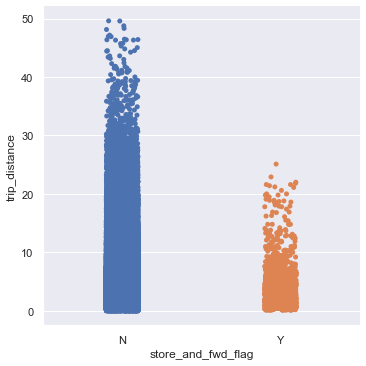

In [82]:
sns.catplot(y='trip_distance', x='store_and_fwd_flag', data=df, kind="strip")

### Trip distance is longer for trips whose flags were not stored.

## Trip distance per time of day

<AxesSubplot:xlabel='pickup_timeofday', ylabel='trip_distance'>

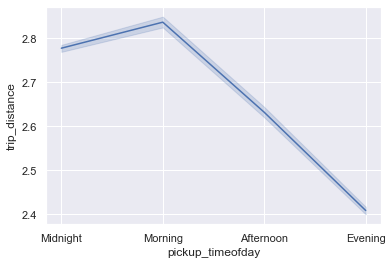

In [83]:
sns.lineplot(x='pickup_timeofday',y='trip_distance',data=df)

### Longest trips are more likely to happen in morning pickup rides.

## Passenger count and Vendor ID

<AxesSubplot:xlabel='VendorID', ylabel='passenger_count'>

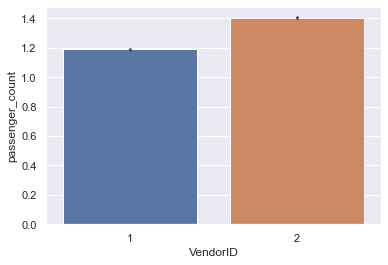

In [84]:
sns.barplot(y='passenger_count', x='VendorID', data=df)

### Vendor 2 carries more passengers per ride than Vendor 1 in general, and both of them are most likely to carry one passenger in a trip.

<AxesSubplot:xlabel='trip_type', ylabel='tip_amount'>

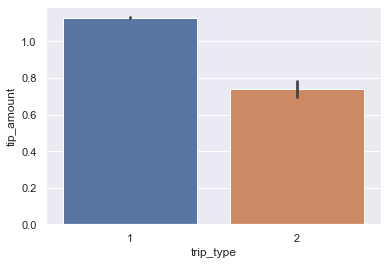

In [85]:
sns.barplot(y='tip_amount',x='trip_type',data=df,estimator=np.mean)

### We can see that trips of street-hail is more likely to yield better tips than trips of dispatch in general.

## All above are my solutions for the Data Science Exercise, thank you for your time and sincerely looking forward to your feedback and advice. Hopefully one day I could work with and learn from you at your esteemed company!